Load libraries and variables.

In [3]:
import os
import json
import chess
import torch.utils.data
from utils import *
from datetime import date
from s03_encode_data import encode
from importlib import import_module
from IPython.display import clear_output, Markdown
from s01_prepare_data import get_board_status

DEVICE = torch.device(
    "cuda" if torch.cuda.is_available() else "cpu"
)

Get configuration.

In [4]:
config_name = "CT_ED_0"
CONFIG = import_module("configs.{}".format(config_name))

Initialize model and load checkpoint.

In [6]:
# Model
model = CONFIG.MODEL(CONFIG).to(DEVICE)

# Checkpoint
checkpoint = torch.load(os.path.join(CONFIG.CHECKPOINT_FOLDER, CONFIG.FINAL_CHECKPOINT))
model.load_state_dict(checkpoint["model_state_dict"])
print("\nLoaded checkpoint.\n")

# Set model to compile
compiled_model = torch.compile(
    model,
    mode=CONFIG.COMPILATION_MODE,
    dynamic=CONFIG.DYNAMIC_COMPILATION,
    disable=CONFIG.DISABLE_COMPILATION,
)
compiled_model.eval()  # eval mode disables dropout

# "Move index to move" mapping
vocabulary = json.load(open(os.path.join(CONFIG.DATA_FOLDER, CONFIG.VOCAB_FILE)))
reverse_move_vocabulary = {v: k for k, v in vocabulary["move_sequence"].items()}



Loaded checkpoint.



Define model and human moves.

In [1]:
def make_model_move(board, k):
    """
    Have the model make the next move at the given board position.

    Args:

        board (chess.Board): The chessboard in its current state.

        k (int): The "k" in "top-k" sampling, for sampling the model's predicted moves.

    Returns:

        chess.Board: The chessboard after the model makes its move.

        str, NoneType: The outcome of the move, if the game ends with this move.
    """
    # Get predictions
    with torch.no_grad():
        board_status = get_board_status(board)
        encoded_board_status = dict()
        for status in board_status:
            encoded_board_status[status] = torch.IntTensor(
                [encode(board_status[status], vocabulary=vocabulary[status])]
            ).to(DEVICE)
            if encoded_board_status[status].dim() == 1:
                encoded_board_status[status] = encoded_board_status[status].unsqueeze(0)
        moves = (
            torch.LongTensor([vocabulary["move_sequence"]["<move>"]]).unsqueeze(0).to(DEVICE)
        )
        lengths = torch.LongTensor([1]).unsqueeze(0).to(DEVICE)
        with torch.autocast(device_type=DEVICE.type, dtype=torch.float16, enabled=CONFIG.USE_AMP):
            predicted_moves = compiled_model(
                turns=encoded_board_status["turn"],
                white_kingside_castling_rights=encoded_board_status[
                    "white_kingside_castling_rights"
                ],
                white_queenside_castling_rights=encoded_board_status[
                    "white_queenside_castling_rights"
                ],
                black_kingside_castling_rights=encoded_board_status[
                    "black_kingside_castling_rights"
                ],
                black_queenside_castling_rights=encoded_board_status[
                    "black_queenside_castling_rights"
                ],
                can_claim_draw=encoded_board_status["can_claim_draw"],
                board_positions=encoded_board_status["board_position"],
                moves=moves,
                lengths=lengths,
            )  # (1, max_move_sequence_length, move_vocab_size)
        predicted_moves = predicted_moves[:, 0, :]  # (1, move_vocab_size)

        # Get list of legal moves at the current position
        legal_moves = [str(m) for m in board.legal_moves if str(m) in vocabulary["move_sequence"]]

        # Perform top-k sampling to obtain a legal predicted move
        legal_move_index = topk_sampling(logits=predicted_moves[:, [vocabulary["move_sequence"][m] for m in legal_moves]], k=k).item()
        model_move = legal_moves[legal_move_index]
                
        # Move
        clear_output(wait=True)
        if len(board.move_stack) == 0:
            display(Markdown(" #  I played ***%s***." % model_move))
        else:
            display(Markdown(" #  You played ***%s***. I played ***%s***." % (str(board.move_stack[-1]), model_move)))
        board.push_uci(model_move)
        if board.is_checkmate():
            clear_output(wait=True)
            display(Markdown("# I played ***%s***. I win! :)" % model_move))
            display(board)
            return board, "0-1" if board.turn else "1-0"
        display(board)
        return board, None

def make_human_move(board):
    """
    Have the human make the next move at the given board position.

    Args:

        board (chess.Board): The chessboard in its current state.

    Returns:

        chess.Board: The chessboard after the human makes their move.

        str, NoneType: The outcome of the move, if the game ends with this move.
    """
    # Get list of legal moves at the current position
    legal_moves = [m.uci() for m in board.legal_moves]

    # Make a move
    while True:
        # What move does the human wish to make?
        human_move = input("What move would you like to play? (UCI notation; 'exit', 'resign', 'draw' are options.)")

        # If it's a legal move
        if human_move in legal_moves:
            board.push_uci(human_move)
            clear_output(wait=True)
            display(Markdown(" # You played ***%s***." % human_move))
            display(board)
            if board.is_checkmate():
                clear_output(wait=True)
                display(Markdown("# You played ***%s***. You win! :(" % human_move))
                display(board)
                return board, "0-1" if board.turn else "1-0"
            return board, None
        
        # If the human wishes to stop playing
        if human_move.lower() == "exit":
            clear_output(wait=True)
            display(Markdown("# You stopped playing."))
            display(board)
            return board, "0-1" if board.turn else "1-0"
        
        # If the human wishes to resign
        if human_move.lower() == "resign":
            clear_output(wait=True)
            display(Markdown("# You resigned."))
            display(board)
            return board, "0-1" if board.turn else "1-0"
        
        # If the human wishes to claim a draw
        if human_move.lower() == "draw":
            if board.can_claim_draw():
                clear_output(wait=True)
                display(Markdown("# You claimed a draw."))
                display(board)
                return board, "1/2-1/2"
            else:
                clear_output(wait=True)
                display(Markdown("# You can't claim a draw right now."))
                display(board)

        # If it isn't a legal move     
        else:
            clear_output(wait=True)
            display(Markdown("# ***%s*** isn't a valid move." % human_move))
            display(board)

Run the model once to trigger compilation. This can take a few moments.

In [13]:
%%capture
_, __ = make_model_move(chess.Board(), k=CONFIG.SAMPLING_K)

Play a game of chess with the model.

# You resigned.

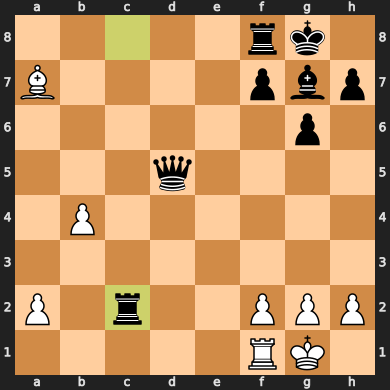

In [14]:
def play(k):
    """
    Play a game of chess against the model.

    Args:

        k (int): The "k" in "top-k" sampling, for sampling the model's predicted moves.

    Returns:

        chess.Board: The played-out chessboard at the end of the game.

        str: The outcome of the game.

        str: Your playing color. One of "w" or "b".
    """
    # What color do you wish to play?
    human_color = None
    while human_color is None:
        human_color = input("Do you want to play white (w) or black (b)?")
        if human_color.lower() not in ["w", "b"]:
            human_color = None

    # Play
    board = chess.Board()
    outcome = None
    if human_color.lower() == "w":
        display(Markdown("# Make the first move."))
        display(board)
        board, outcome = make_human_move(board)
    while outcome is None and not board.is_game_over():
        board, outcome = make_model_move(board, k=k)
        if outcome is outcome is None and not board.is_game_over():
            board, outcome = make_human_move(board)

    return board, outcome, human_color.lower()

board, outcome, human_color = play(k=CONFIG.SAMPLING_K)

Print a short summary of the game if you wish to save it.

In [15]:
def get_pgn(board, human_color, outcome):
    """
    Get PGN of a game represented by a played-out chessboard.

    Args:

        board (chess.Board): The played-out chessboard.

        human_color (str): Your playing color. One of "w" or "b".

        outcome (str, NoneType): The outcome of the game, if there was one.

    Returns:

        str: The PGN of the game.
    """
    game = chess.pgn.Game.from_board(board)

    game.headers["Result"] = outcome if outcome else board.result()
    game.headers["Event"] = "You vs. Chess Transformer"
    game.headers["Site"] = "github.com/sgrvinod/chess-transformer"
    game.headers["Date"] = date.today().strftime("%Y/%m/%d")
    game.headers["Round"] = "1"
    game.headers["White"] = "You" if human_color == "w"  else "Chess Transformer"
    game.headers["Black"] = "You" if human_color == "b"  else "Chess Transformer"

    return str(game)

print(get_pgn(board, human_color, outcome))

[Event "You vs. Chess Transformer"]
[Site "github.com/sgrvinod/chess-transformer"]
[Date "2023/08/29"]
[Round "1"]
[White "You"]
[Black "Chess Transformer"]
[Result "0-1"]

1. e4 c5 2. Nc3 Nc6 3. Nf3 g6 4. d4 cxd4 5. Nxd4 Bg7 6. Nxc6 bxc6 7. Be3 Nf6 8. Bd3 O-O 9. O-O d5 10. exd5 cxd5 11. b4 e5 12. Qf3 e4 13. Qe2 exd3 14. Qxd3 Bf5 15. Qd2 Ne4 16. Nxe4 Bxe4 17. Rad1 Rc8 18. Qxd5 Bxd5 19. Rxd5 Qxd5 20. Bxa7 Rxc2 0-1
